In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from eofs.multivariate.standard import MultivariateEof
from sklearn.preprocessing import StandardScaler, power_transform
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from eofs.standard import Eof
from pathlib import Path


In [ ]:
directory_path = Path('CompleteData')
files_only = [entry.name for entry in directory_path.iterdir() if entry.is_file()]

In [287]:
first_step = True
center_pressure = []
gh = []
t = []
rh = []
radius = []
angle = []
for file in files_only:
    complete_path = "CompleteData/" + file
    with open(complete_path, 'rb') as f:
        loaded_data = pickle.load(f)
    if first_step:
        center_pressure = loaded_data['center_pressure']
        gh = loaded_data['gh']
        t = loaded_data['t']
        rh = loaded_data['r']
        radius = loaded_data['radius_coords'][0]
        angle = loaded_data['angle_coords'][0]
        first_step = False
    else:
        center_pressure = np.concatenate([center_pressure, loaded_data['center_pressure']])
        gh = np.concatenate([gh, loaded_data['gh']])
        t = np.concatenate([t, loaded_data['t']])
        rh = np.concatenate([rh, loaded_data['r']])

In [288]:
total_samples = len(center_pressure)
print(f'There are {total_samples} samples' )

There are 506 samples


Text(0.5, 0, 'Minimum Central Pressure')

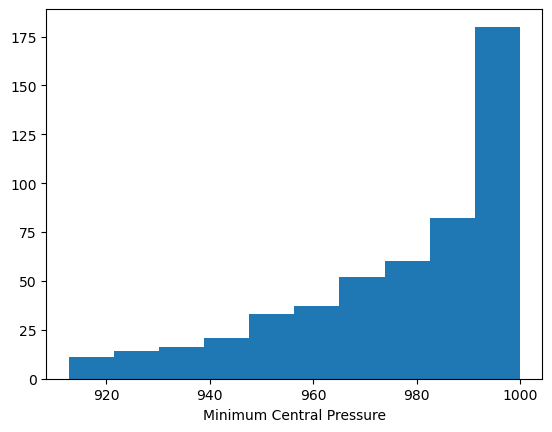

In [289]:
plt.hist(center_pressure)
plt.xlabel('Minimum Central Pressure')

In [290]:
gh_clean = []
t_clean = []
rh_clean = []
center_pressure_clean = []

drop_frames = []
for i in range(101):
    if (np.sum(np.isnan(gh[i,:,:]), axis = None)
        or np.sum(np.isnan(t[i,:,:]), axis = None)
        or np.sum(np.isnan(rh[i,:,:]), axis = None)):
        print(f"Frame {i} has NaNs")
    else:
        gh_clean.append(gh[i,:,:])
        rh_clean.append(rh[i,:,:])
        t_clean.append(t[i,:,:])
        center_pressure_clean.append(center_pressure[i])

gh_clean = np.concatenate([gh_clean])
rh_clean = np.concatenate([rh_clean])
t_clean = np.concatenate([t_clean])
center_pressure_clean = np.concatenate([center_pressure_clean])

Frame 37 has NaNs
Frame 76 has NaNs
Frame 84 has NaNs
Frame 85 has NaNs
Frame 86 has NaNs
Frame 87 has NaNs
Frame 98 has NaNs


Text(20, 8000000.0, 'Skewness :-1.3885364532470703')

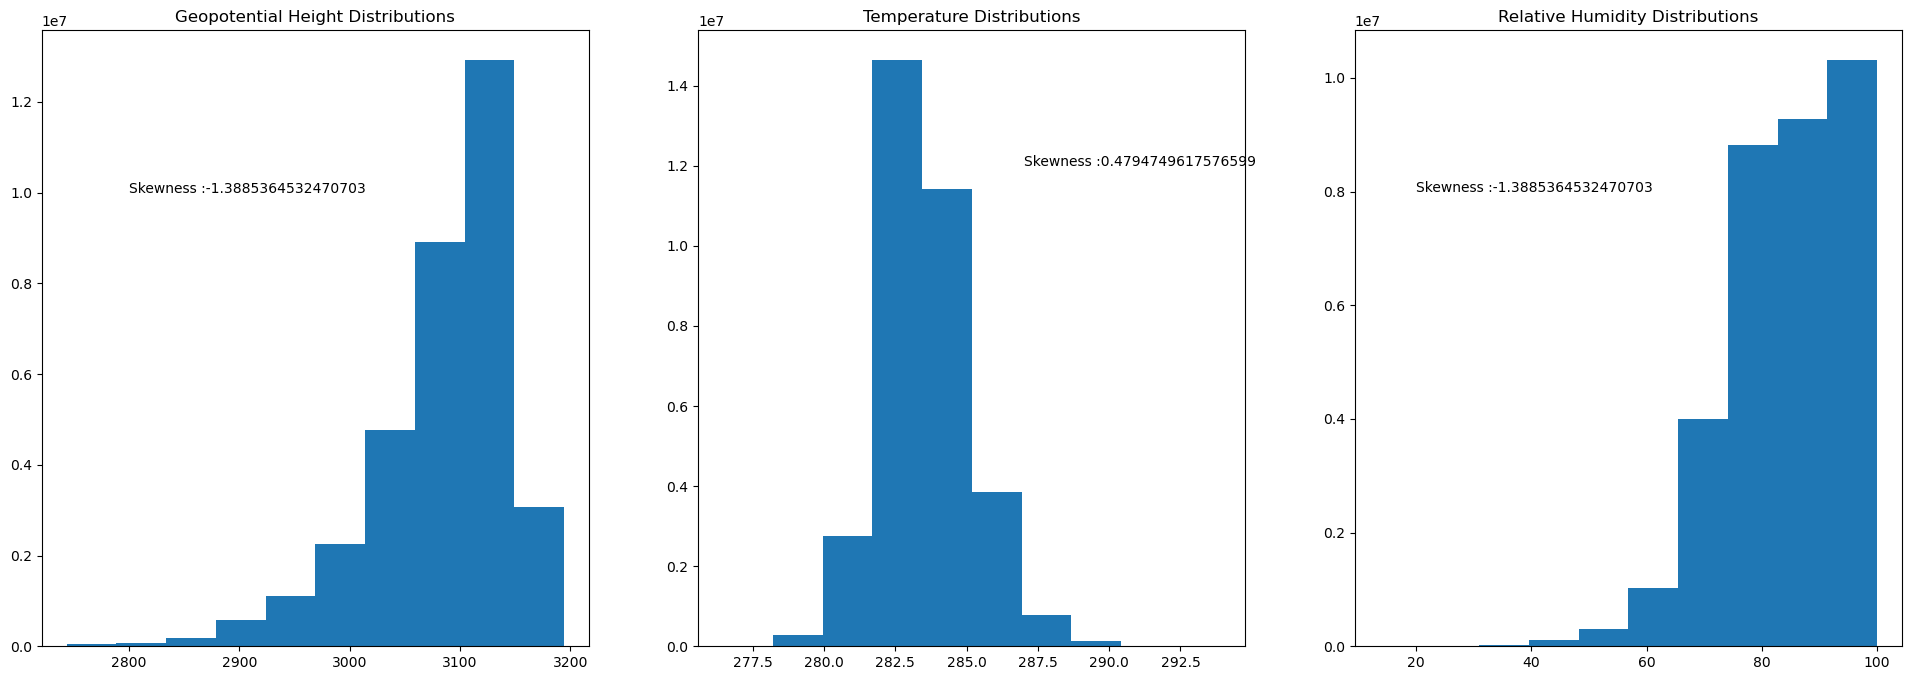

In [292]:
# Deciding on scalers

# for reshaping
total_samples = len(center_pressure_clean)
radius_dim = len(radius)
angle_dim = len(angle)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(gh_clean.reshape(total_samples * radius_dim * angle_dim))
ax[1].hist(t_clean.reshape(total_samples * radius_dim * angle_dim))
ax[2].hist(rh_clean.reshape(total_samples * radius_dim * angle_dim))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(gh_clean.reshape(total_samples * radius_dim * angle_dim))
t_skew = scipy.stats.skew(t_clean.reshape(total_samples * radius_dim * angle_dim))
rh_skew = scipy.stats.skew(gh_clean.reshape(total_samples * radius_dim * angle_dim))

ax[0].text(x = 2800, y = 10**7,  s = f'Skewness :{gh_skew}')
ax[1].text(x = 287, y = 1.2 * 10**7, s = f'Skewness :{t_skew}')
ax[2].text(x = 20, y = .8 * 10**7, s = f'Skewness :{rh_skew}')

In [293]:
# Normalizing the Data
scaler = StandardScaler()
gh_std = power_transform(gh_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 
rh_std = power_transform(rh_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 
t_std = scaler.fit_transform(t_clean.reshape((total_samples, angle_dim*radius_dim))).reshape((total_samples, angle_dim, radius_dim)) 

Text(-4, 6000000, 'Skewness :-0.8049213886260986')

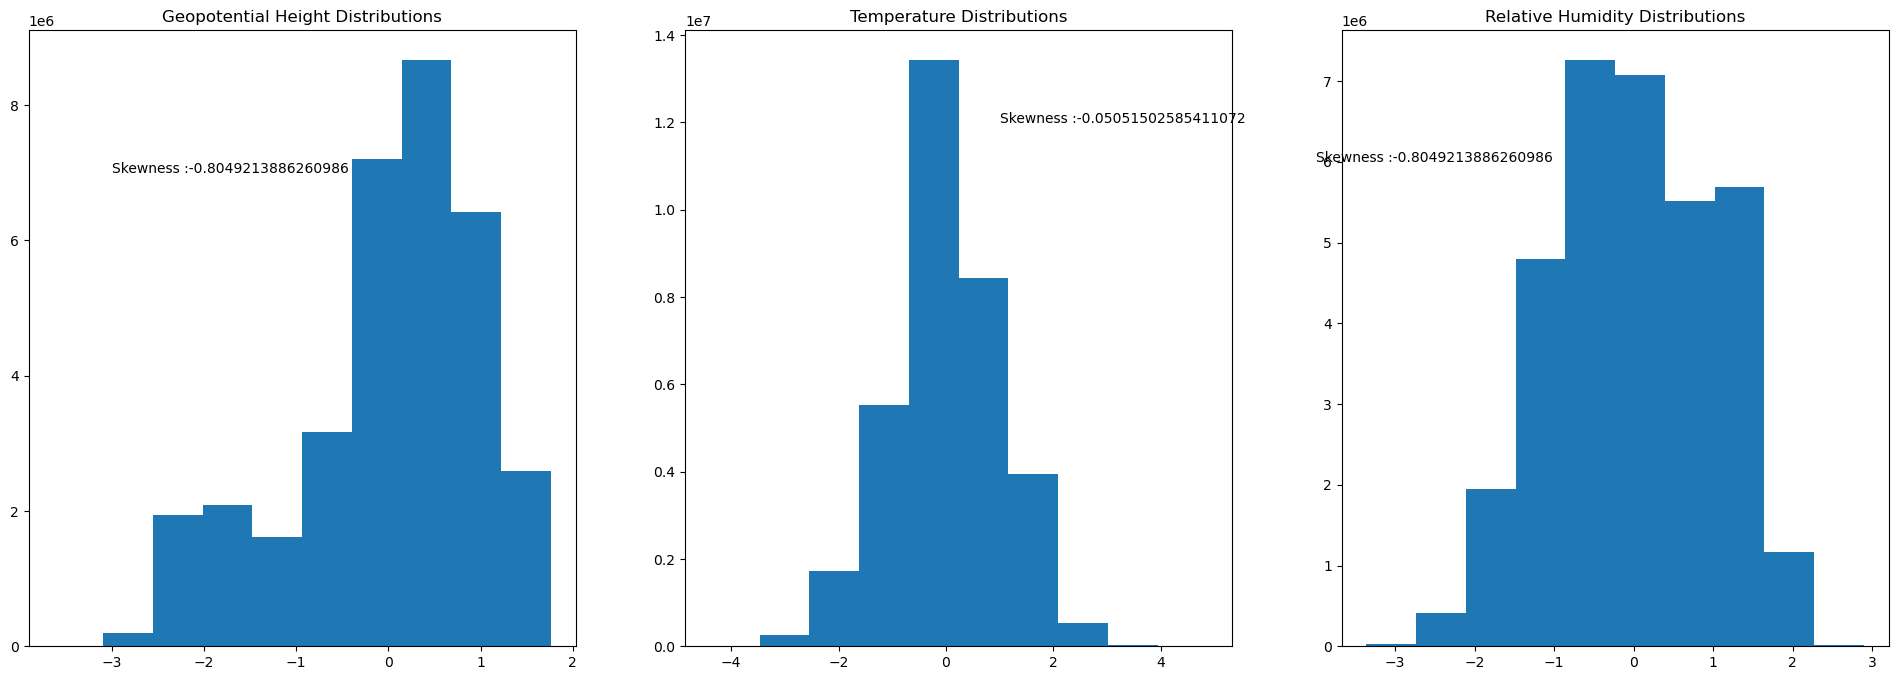

In [294]:
# for reshaping
total_samples = len(center_pressure_clean)
radius_dim = len(radius)
angle_dim = len(angle)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24,8))

ax[0].hist(gh_std.reshape(total_samples * radius_dim * angle_dim))
ax[1].hist(t_std.reshape(total_samples * radius_dim * angle_dim))
ax[2].hist(rh_std.reshape(total_samples * radius_dim * angle_dim))

ax[0].set_title('Geopotential Height Distributions')
ax[1].set_title('Temperature Distributions')
ax[2].set_title('Relative Humidity Distributions')

gh_skew = scipy.stats.skew(gh_std.reshape(total_samples * radius_dim * angle_dim))
t_skew = scipy.stats.skew(t_std.reshape(total_samples * radius_dim * angle_dim))
rh_skew = scipy.stats.skew(gh_std.reshape(total_samples * radius_dim * angle_dim))

ax[0].text(x = -3, y = 7*10**6,  s = f'Skewness :{gh_skew}')
ax[1].text(x = 1, y = 1.2 * 10**7, s = f'Skewness :{t_skew}')
ax[2].text(x = -4, y = 6 * 10**6, s = f'Skewness :{rh_skew}')


In [295]:
# indexes based on pressure

index_985 = np.where(center_pressure_clean >= 980)
index_980_960 = np.where((980 > center_pressure_clean) & (center_pressure_clean >= 960))
index_960 = np.where((960 > center_pressure_clean))

In [296]:
#creating composites based on pressure ranges

gh_980 = np.nanmean(gh_clean[index_985], axis = 0)
t_980 = np.nanmean(t_clean[index_985], axis = 0)
rh_980 = np.nanmean(rh_clean[index_985], axis = 0)
gh_980_960 = np.nanmean(gh_clean[index_980_960], axis = 0)
t_980_960 = np.nanmean(t_clean[index_980_960], axis = 0)
rh_980_960 = np.nanmean(rh_clean[index_980_960], axis = 0)
gh_960 = np.nanmean(gh_clean[index_960], axis = 0)
t_960 = np.nanmean(t_clean[index_960], axis = 0)
rh_960 = np.nanmean(rh_clean[index_960], axis = 0)

Text(0.5, 0.98, 'Tropical Cyclone Variable Composites based on Minimum Central Pressure')

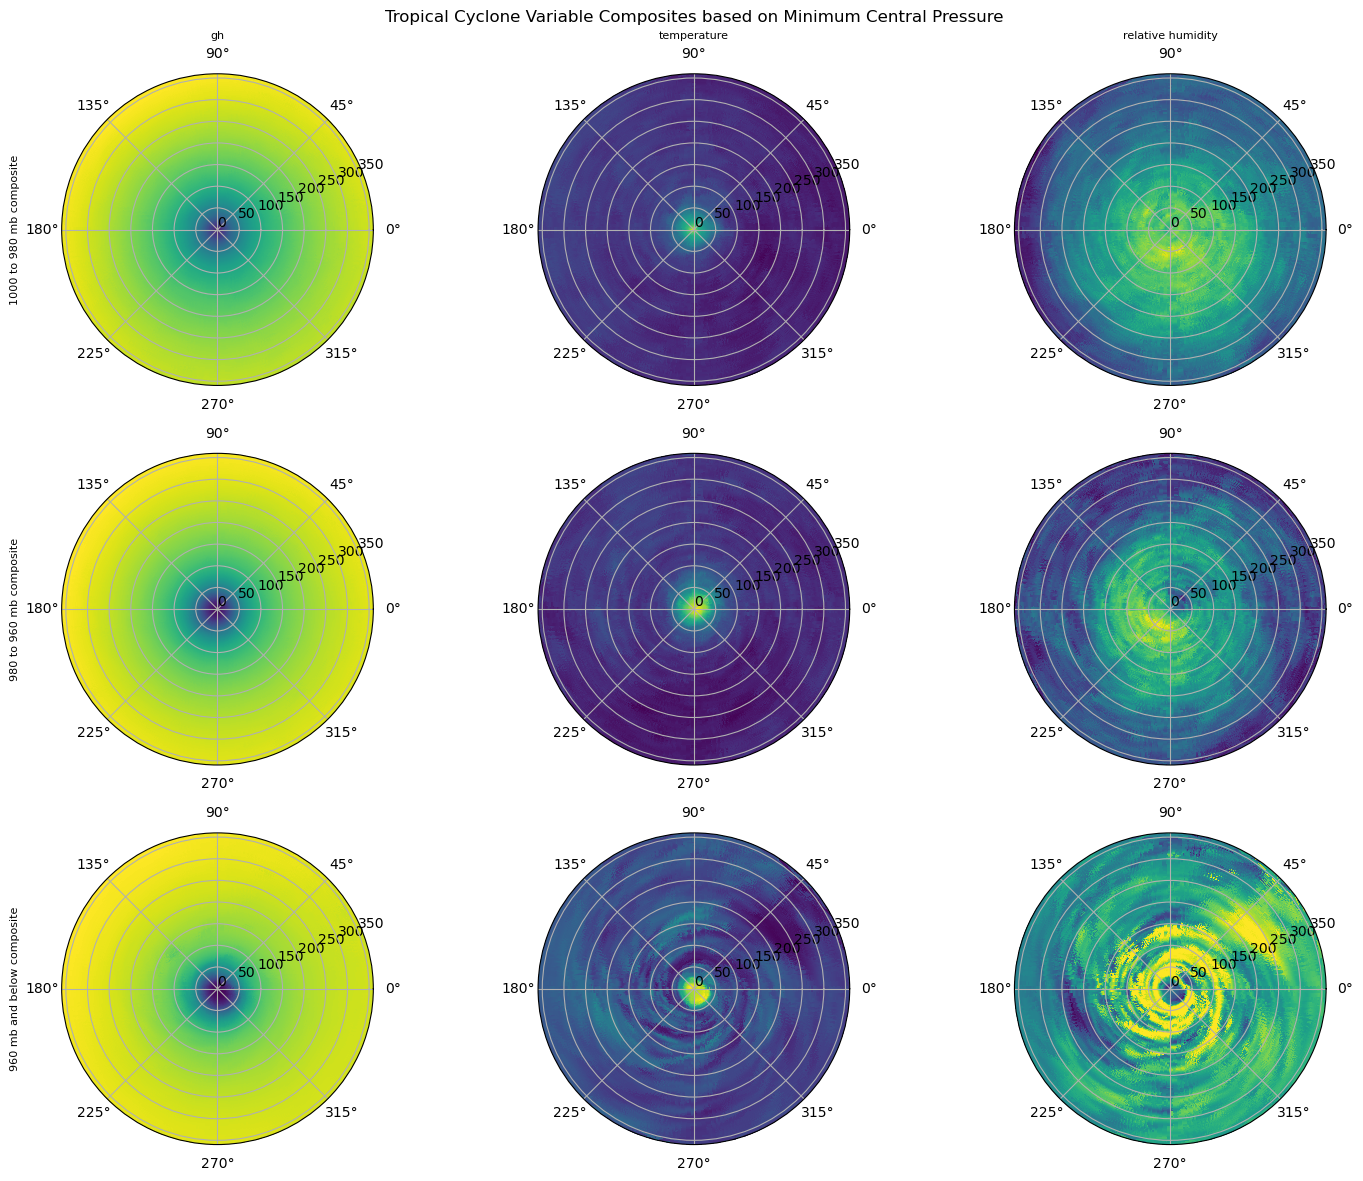

In [297]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_980)
ax[0,1].pcolormesh(R, Theta, t_980)
ax[0,2].pcolormesh(R, Theta, rh_980)
ax[1,0].pcolormesh(R, Theta, gh_980_960)
ax[1,1].pcolormesh(R, Theta, t_980_960)
ax[1,2].pcolormesh(R, Theta, rh_980_960)
ax[2,0].pcolormesh(R, Theta, gh_960)
ax[2,1].pcolormesh(R, Theta, t_960)
ax[2,2].pcolormesh(R, Theta, rh_960)

ax[0,0].set_ylabel('1000 to 980 mb composite', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('980 to 960 mb composite', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('960 mb and below composite', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('Tropical Cyclone Variable Composites based on Minimum Central Pressure')

Calculating weights and constructing EOFs

In [298]:
max_range = 250.0
range_step = 0.5
angle_step = 0.5
range_gates = np.arange(0.0, max_range + range_step, range_step)

areas = []

for i, r in enumerate(range_gates):
    
    area = (angle_step/360) * np.pi * ((r + range_step)**2 - r**2)
    areas.append(area)

area_weight = areas/np.max(areas)

In [299]:
msolver = MultivariateEof([gh_std,t_std,rh_std], weights=[area_weight, area_weight, area_weight])
gh_eof, t_eof, rh_eof = msolver.eofsAsCorrelation(neofs=10)

In [300]:
pcs = msolver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

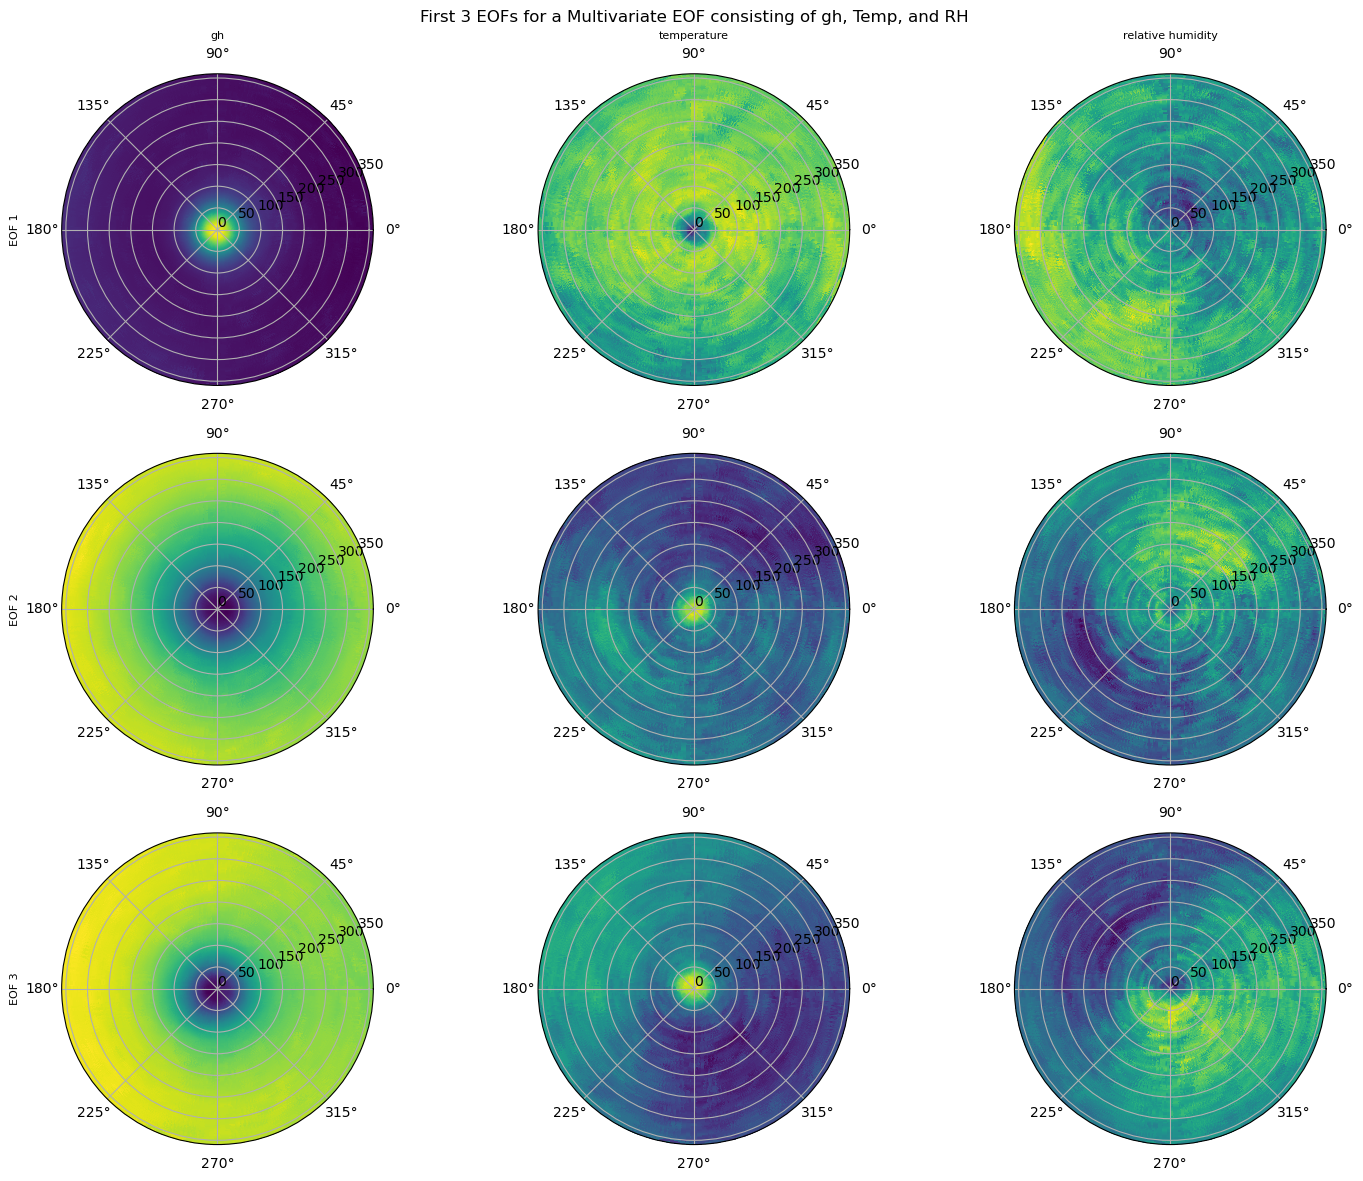

In [301]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for a Multivariate EOF consisting of gh, Temp, and RH')

Text(0.5, 0, 'EOF number')

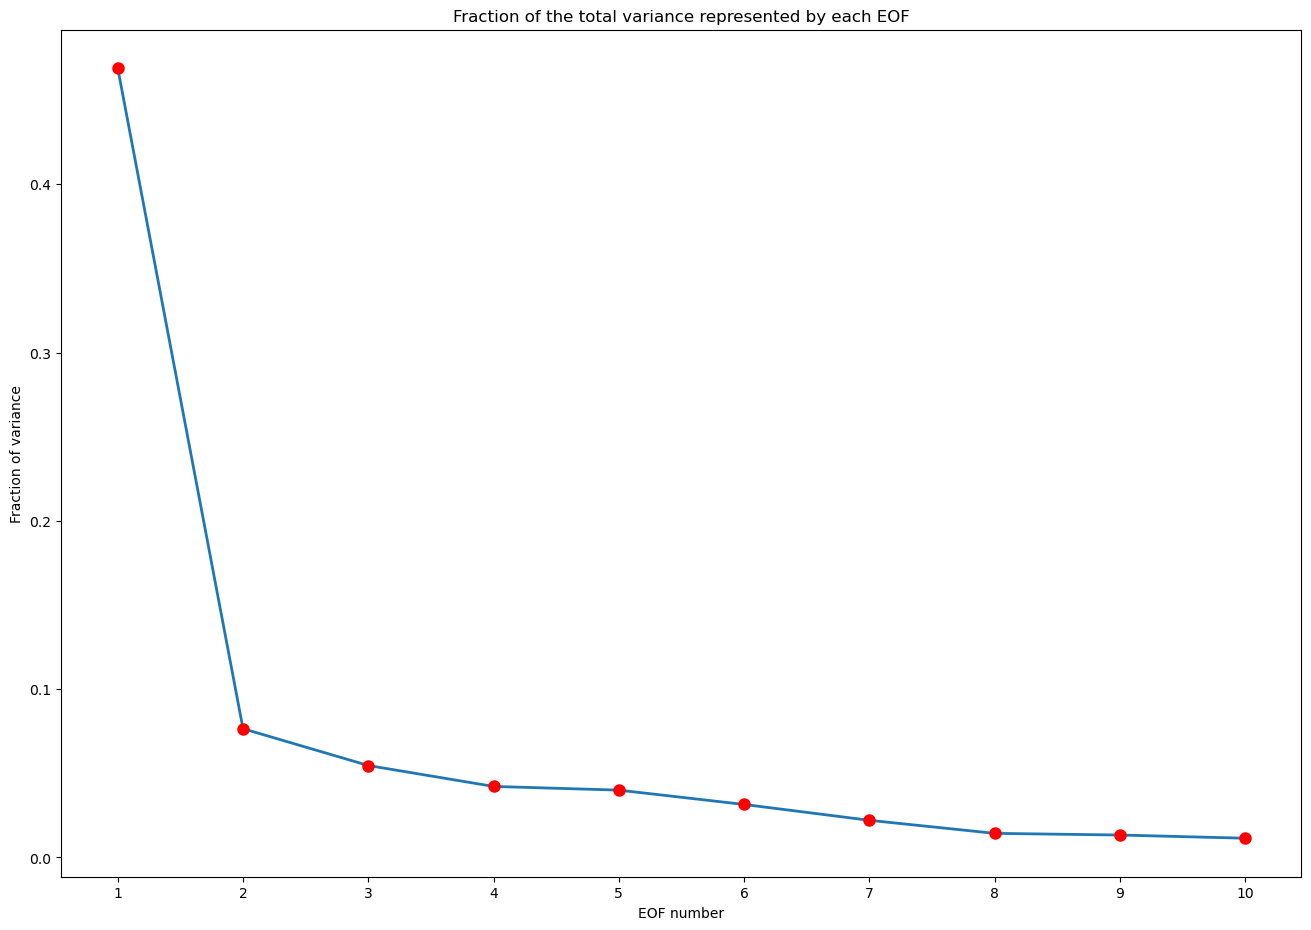

In [302]:
# Looking at the Variance

varfrac = msolver.varianceFraction()

# Plot the fraction of variance explained by each EOF

plt.figure(figsize = (16,11))
eof_num = range(1,11)
plt.plot(eof_num, varfrac[0:10], linewidth = "2")
plt.plot(eof_num, varfrac[0:10], linestyle = "None", marker = "o", color = "r", markersize = 8)
plt.xticks(range(1,11))
plt.title("Fraction of the total variance represented by each EOF")
plt.ylabel("Fraction of variance")
plt.xlabel("EOF number")

In [ ]:
np.shape(pcs)

In [303]:
lin_model = LinearRegression()
scores = cross_val_score(lin_model, pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

EOF as a function of Geopotential Height, Temperature, and Relative Humidity skill

In [304]:
rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [3.49949948 5.51398959 6.24619545 8.51580255 6.26029689 2.96881294
 2.86420766]
Mean RMSE:  5.124114936369733
RMSE Std:  1.9492637492987868


Examining Single Variate EOFs of each variable

In [309]:
gh_solver = Eof(gh_std, weights=area)
gh_only_eof = gh_solver.eofsAsCorrelation(neofs = 10)
gh_only_pcs = gh_solver.pcs(npcs = 3)

In [310]:
t_solver = Eof(t_std, weights=area)
t_only_eof = t_solver.eofsAsCorrelation(neofs = 10)
t_only_pcs = t_solver.pcs(npcs = 3)


In [311]:
rh_solver = Eof(rh_std, weights=area)
rh_only_eof = rh_solver.eofsAsCorrelation(neofs = 10)
rh_only_pcs = rh_solver.pcs(npcs = 3)

Text(0.5, 0.98, 'First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

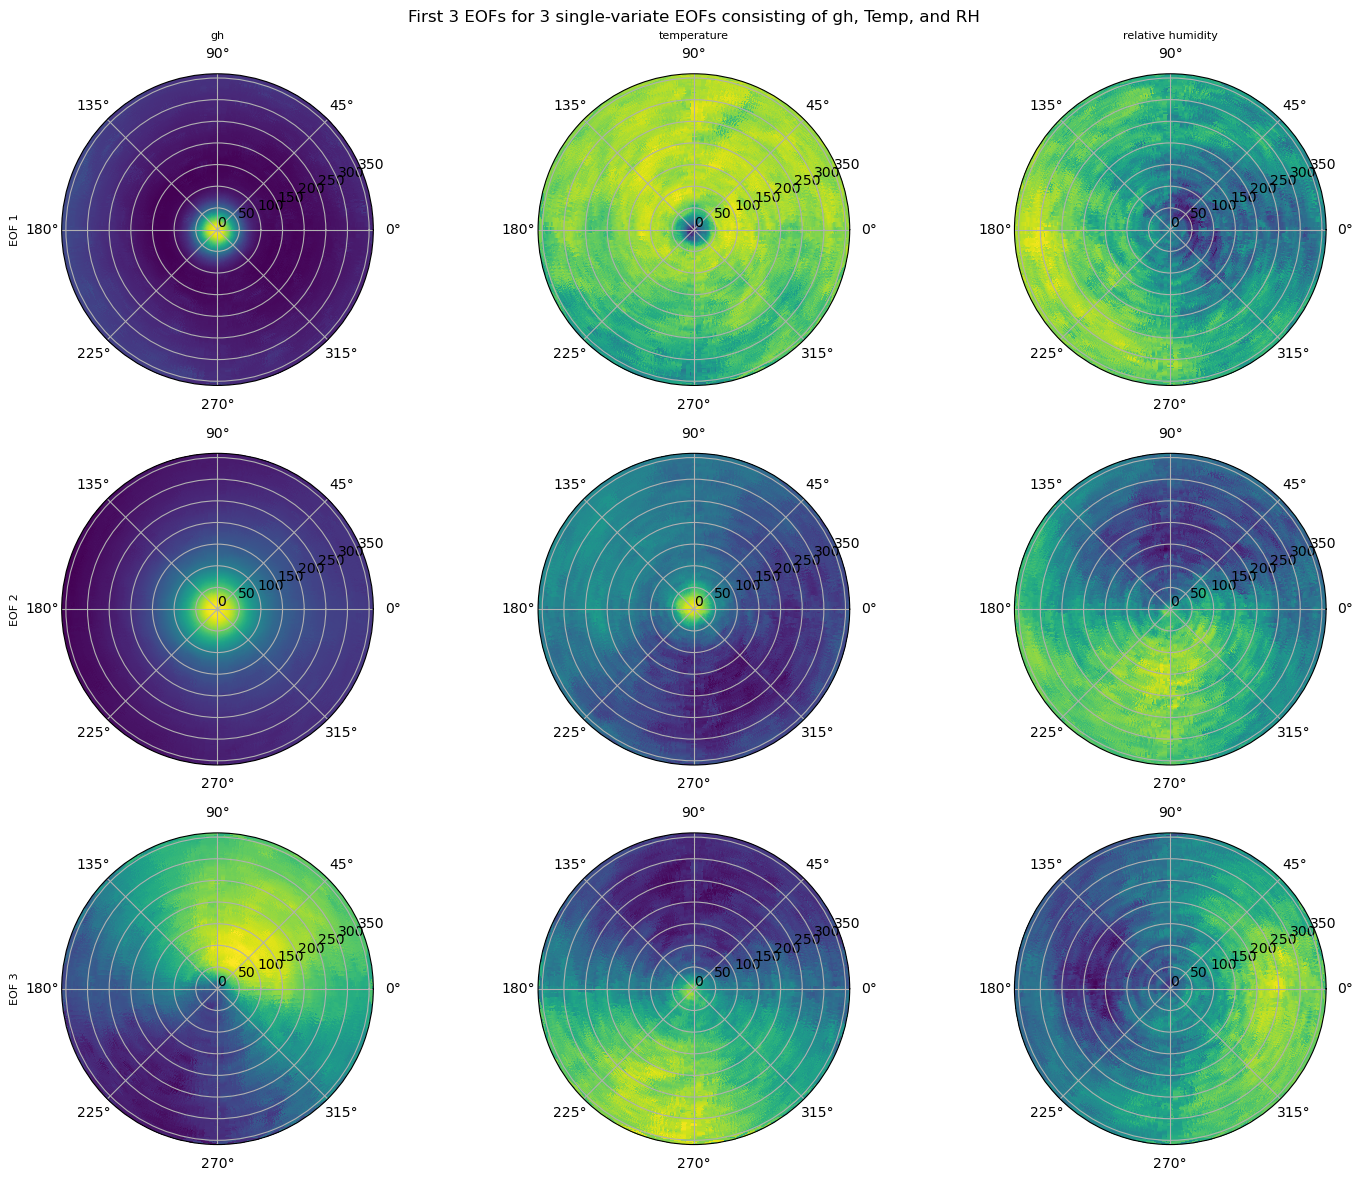

In [312]:
fig, ax = plt.subplots(nrows= 3, ncols=3, figsize=(16, 12),subplot_kw={'projection': 'polar'})

R, Theta = np.meshgrid(radius, angle)


ax[0,0].pcolormesh(R, Theta, gh_only_eof[0,:,:])
ax[0,1].pcolormesh(R, Theta, t_only_eof[0,:,:])
ax[0,2].pcolormesh(R, Theta, rh_only_eof[0,:,:])
ax[1,0].pcolormesh(R, Theta, gh_only_eof[1,:,:])
ax[1,1].pcolormesh(R, Theta, t_only_eof[1,:,:])
ax[1,2].pcolormesh(R, Theta, rh_only_eof[1,:,:])
ax[2,0].pcolormesh(R, Theta, gh_only_eof[2,:,:])
ax[2,1].pcolormesh(R, Theta, t_only_eof[2,:,:])
ax[2,2].pcolormesh(R, Theta, rh_only_eof[2,:,:])

ax[0,0].set_ylabel('EOF 1', fontsize = 8, labelpad = 30)
ax[1,0].set_ylabel('EOF 2', fontsize = 8, labelpad = 30)
ax[2,0].set_ylabel('EOF 3', fontsize = 8, labelpad = 30)

ax[0,0].set_title('gh', fontsize = 8)
ax[0,1].set_title('temperature', fontsize = 8)
ax[0,2].set_title('relative humidity', fontsize = 8)

fig.set_tight_layout(tight = True)
fig.suptitle('First 3 EOFs for 3 single-variate EOFs consisting of gh, Temp, and RH')

GH Only Scores

In [313]:
scores = cross_val_score(lin_model, gh_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())



RMSE scores:  [2.26640451 4.57764059 3.60255068 5.05977725 2.18932334 2.48905921
 3.6254076 ]
Mean RMSE:  3.401451882615921
RMSE Std:  1.056551554761445


Temperature Only Scores

In [314]:
scores = cross_val_score(lin_model, t_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [ 9.36367154  6.56341546 10.63018985  8.19344906 11.44927831  8.90277189
  5.42940232]
Mean RMSE:  8.647454061588725
RMSE Std:  1.9735685369811589


RH Only Scores

In [315]:
scores = cross_val_score(lin_model, rh_only_pcs, center_pressure_clean, scoring = 'neg_mean_squared_error', cv = 7)

rmse_scores = np.sqrt(-scores)
print("RMSE scores: ", rmse_scores)
print("Mean RMSE: ", rmse_scores.mean())
print("RMSE Std: ", rmse_scores.std())

RMSE scores:  [ 7.69880865  7.52657876 12.69540087 10.42204488 15.10332144  9.6955845
 10.38202096]
Mean RMSE:  10.503394294151748
RMSE Std:  2.4889831486514233
